<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_15_%EB%AA%A9(NPLM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense,  Flatten, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


texts = ['The cat is walking in the bedroom.',
         'A dog was running in a room',
         'The cat is running in a room',
         'A dog is walking in a bedroom',
         'The dog was walking in the room']

In [6]:
# 특수문자 제거, 대문자를 소문자로 변환
clean_texts = [[re.sub('[^a-z]','',tok.lower()) for tok in txt.split()] for txt in texts]

In [7]:
clean_texts

[['the', 'cat', 'is', 'walking', 'in', 'the', 'bedroom'],
 ['a', 'dog', 'was', 'running', 'in', 'a', 'room'],
 ['the', 'cat', 'is', 'running', 'in', 'a', 'room'],
 ['a', 'dog', 'is', 'walking', 'in', 'a', 'bedroom'],
 ['the', 'dog', 'was', 'walking', 'in', 'the', 'room']]

In [8]:
# 단어사전을 위한 딕셔너리
word2idx = defaultdict(int) 

In [9]:
# 카운트를 1부터 증가시켜주면서 단어사전을 생성
cnt = 1
for text in clean_texts:
  for tok in text:
    if word2idx[tok] == 0:
      word2idx[tok] = cnt
      cnt +=1
word2idx

defaultdict(int,
            {'a': 7,
             'bedroom': 6,
             'cat': 2,
             'dog': 8,
             'in': 5,
             'is': 3,
             'room': 11,
             'running': 10,
             'the': 1,
             'walking': 4,
             'was': 9})

In [24]:
# index to word dictionary
idx2word = {v:k for k, v in word2idx.items()}
idx2word 

{1: 'the',
 2: 'cat',
 3: 'is',
 4: 'walking',
 5: 'in',
 6: 'bedroom',
 7: 'a',
 8: 'dog',
 9: 'was',
 10: 'running',
 11: 'room'}

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5]),
 <a list of 10 Patch objects>)

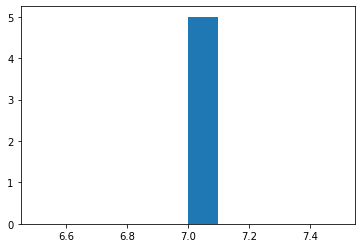

In [25]:
text_lenghts = [len(x) for x in clean_texts]
plt.hist(text_lenghts)

In [26]:
# 문장들 중에서 가장 짧은 문장의 길이를 저장. (n_gram 생성시 가장 짧은 문장을 기준으로 생성)
min_len = min(text_lenghts)
print(min_len)

7


In [27]:
# 단어의 배열
text_sequences = [[word2idx[tok] for tok in tokens] for tokens in clean_texts]
print(text_sequences)

[[1, 2, 3, 4, 5, 1, 6], [7, 8, 9, 10, 5, 7, 11], [1, 2, 3, 10, 5, 7, 11], [7, 8, 3, 4, 5, 7, 6], [1, 8, 9, 4, 5, 1, 11]]


In [28]:
train_x = []
train_y = []
# n_gram
for n_gram in range(1, min_len):
  start_idx = n_gram
  # 문장의 끝까지 순회하면서
  for sequence in text_sequences:
    for i in range(start_idx, len(sequence)):
      train_x.append(sequence[i-n_gram:i])
      train_y.append(sequence[i])

# 훈련데이터 셋의 개수 출력
print(len(train_x), len(train_y))

105 105


In [29]:
print(train_x[0:10])
print(train_y[0:10])

[[1], [2], [3], [4], [5], [1], [7], [8], [9], [10]]
[2, 3, 4, 5, 1, 6, 8, 9, 10, 5]


In [30]:
# 제로 패딩을 텍스트 앞에 넣어줍니다. 
x_train = pad_sequences(train_x, maxlen=min_len, padding='pre', truncating='post')
y_train = np.array(train_y)

In [31]:
x_train[:10]

y_train[:10]

array([ 2,  3,  4,  5,  1,  6,  8,  9, 10,  5])

In [32]:
# Embedding & LSTM 모델을 생성한다.
vocab_size = len(word2idx)+1
EMBEDDING_DIM = 8
HIDDEN_DIM = 32

x_input = Input(batch_shape=(None, x_train.shape[1])) # (none, 7)
e_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM)(x_input) # 11개의 단어를 8차원으로 바꿔주는 임배딩 레이어

flatten_layer = Flatten()(e_layer) # 7개의 단어를 1열로 나열

hidden_layer = Dense(HIDDEN_DIM, activation='tanh')(flatten_layer) #(d+Hx)
U = Dense(vocab_size)(hidden_layer) # Utanh(d+Hx)

W = Dense(vocab_size)(flatten_layer) #W(x)
# 
add_layer = Add()([U,W]) # b + W(x)
y_output = Dense(vocab_size, activation='softmax')(add_layer)

model_vec = Model(x_input, e_layer)
model = Model(x_input, y_output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 7, 8)         96          input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 56)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           1824        flatten_1[0][0]                  
____________________________________________________________________________________________

In [33]:
import keras
earlystop_callback= keras.callbacks.EarlyStopping(
    monitor='val_loss', # val_loss를 지정하겠다.
    patience=10, # 10번의 튕김을 참겠다.
    mode='min' , # monitor 값이 최소가 되어야 한다.
    restore_best_weights=True # 멈춘 후, 최적이었떤 값으로 모델의 파마리터 값들을 되돌린다.
)

In [34]:
hist = model.fit(x_train, y_train, epochs=100, verbose=1,validation_split=0.2, callbacks=earlystop_callback)

Epoch 1/100
3/3 [==============================] - 1s 73ms/step - loss: 2.4597 - val_loss: 2.3310
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 2.2800 - val_loss: 2.0770
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 2.0585 - val_loss: 1.7301
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 1.7770 - val_loss: 1.3590
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 1.4957 - val_loss: 1.0611
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2111 - val_loss: 0.8137
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.9872 - val_loss: 0.6860
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.8264 - val_loss: 0.6457
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 0.7353 - val_loss: 0.6391
Epoch 10/100
3/3 [==============================] - 0s 13ms/step - loss: 0.6645 - val_loss: 0.5599
Epoch 11/100
3/3 [=

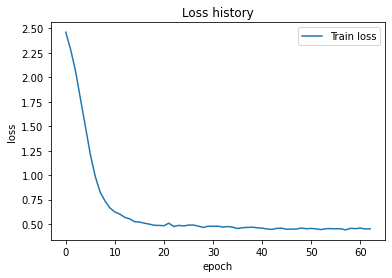

In [35]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [36]:
"""## 문장 다음에 올 단어를 예측해본다."""

# 테스트 데이터 생성
test_text =[ ['the','cat','is'],['a','dog','was'],['dog'],['the','bedroom'],['a','cat','is'],['a','was','walking']]
sequence_test_x = [ [word2idx[tok] for tok in tokens] for tokens in test_text]
padded_sequence_x = pad_sequences(sequence_test_x,maxlen=min_len, padding='pre', truncating='post')

padded_sequence_x

predictions = model.predict(padded_sequence_x)

pred_y = []
for pred in predictions:
  # index 를 다시 word로 바꾸어준다.
  pred_y.append((idx2word[np.argmax(pred)], np.max(pred)))

# 다음에 올 것으로 예측되는 단어
print(pred_y) #[['walking', 'running', 'was', 'was', 'running', 'in']

"""## 예측"""

for i in range(len(test_text)):
  print('입력단어: ',test_text[i],' 출력단어:',pred_y[i][0] , ' 확률: ', pred_y[i][1])
# 입력단어:  ['the', 'cat', 'is']  출력단어: walking  확률:  0.6270845
# 입력단어:  ['a', 'dog', 'was']  출력단어: running  확률:  0.6979395
# 입력단어:  ['dog']  출력단어: was  확률:  0.8006019
# 입력단어:  ['the', 'bedroom']  출력단어: was  확률:  0.36387834
# 입력단어:  ['a', 'cat', 'is']  출력단어: running  확률:  0.79459757
# 입력단어:  ['a', 'was', 'walking']  출력단어: in  확률:  0.99993753

"""## Dog의 Word Vector """

test_text =[['dog']]
sequence_test_x = [ [word2idx[tok] for tok in tokens] for tokens in test_text]
padded_sequence_x = pad_sequences(sequence_test_x,maxlen=min_len, padding='pre', truncating='post')

sequence_vector = model_vec.predict(padded_sequence_x)[0]

len(sequence_vector)

# dog 단어의 vector를 출력한다. dog를 sequence의 제일 뒤에 넣었기 때문에 제일 뒤의 행을 출력해주면 된다.
print(sequence_vector[-1]) #[ 0.42155388  0.16909826  0.05765925  0.2591201   0.3168794  -0.3214157 -0.03524286 -0.15649182]

[('walking', 0.6555379), ('running', 0.6478092), ('was', 0.7219679), ('in', 0.6597722), ('running', 0.76698774), ('in', 0.99999857)]
입력단어:  ['the', 'cat', 'is']  출력단어: walking  확률:  0.6555379
입력단어:  ['a', 'dog', 'was']  출력단어: running  확률:  0.6478092
입력단어:  ['dog']  출력단어: was  확률:  0.7219679
입력단어:  ['the', 'bedroom']  출력단어: in  확률:  0.6597722
입력단어:  ['a', 'cat', 'is']  출력단어: running  확률:  0.76698774
입력단어:  ['a', 'was', 'walking']  출력단어: in  확률:  0.99999857
[ 0.47451073 -0.13686393  0.3836244  -0.2665664   0.02442183 -0.34925136
  0.0492247   0.40745434]
